# CS437 Deep Learning PA1 (part 1)

*__Submission Instructions:__*
- Rename this notebook to `CS437-PA1-p1_Rollnumber.ipynb` before submission on LMS.
- All code must be written in this notebook (you do not need to submit any other files).
- The output of all cells must be present in the version of the notebook you submit. You will be penalized if the output is absent.
- The university honor code should be maintained. Any violation, if found, will result in disciplinary action. 
- You have to download assignment from LMS and do all your workings on colab. Don't download the files again and again.
- __Share the notebook link of your colab noteboob in the begining of the notebook.__

In [172]:
import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from IPython.display import Image
import pydot
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.datasets import make_moons
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf

/var/folders/l8/nqt3x5yn28z6g3mdkkcd_w940000gn/T/ipykernel_22159/1517711870.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


**Please write your roll number in the next cell**

In [173]:
rollnumber = 24100103
# collab_link= 

In this assignment you will be creating a class of the `NeuralNetwork` class. You will implement a version which can create networks of arbitrary shape and depth, and which will work for both regression and classification tasks.

Often in pratical situations, raw machine learning architecture and code is hidden behind libraries and simplfied toolkits. The purpose of this assignment is to lift that curtain and get you hands-on exprience working with the mathematical fundamentals of neural network architectures. After this, you'll know exactly how a network leverages 'gradient descent' to find optimal solutions and how forward and backward passes are implemented mathematically and in code.


### Primary Task
Skeleton code is provided to get you started; the main methods you need to implement correspond to the 3 steps of the training process, namely:
1. Initialize variables and initialize weights
2. Forward pass
3. Backward pass AKA Backpropogation
4. Weight Update AKA Gradient Descent

__Look for comments in the code to see where you are supposed to write code.__ Essentially, you will be working on 5 functions. 
You should use the lecture slides as reference for the equations. 

A `fit` function is what combines the previous three functions and overall trains the network to __fit__ to the provided training examples. In all the following tasks, the provided `fit` methods require the three steps of the training process to be correctly working. The function has been setup in a way that it expects the above 3 methods to take particular inputs and return particular outputs. __You are supposed to work within this restriction.__ Modification of the provided code without prior discussion with the TAs will result in a __grade deduction__. 



To see how well your model is doing, you need to look at the dummy tasks (at the end) and make sure your model loss is going down during training. A dummy regression task of adding two numbers (sum less than 1) has been provided as well. Similarly, a dummy classification task (XOR logic gate) is also present. You can look at the shapes of the inputs and outputs matrices as well as the training trend (once you implement a full task) by using your own class (make sure you are using the correct arguments to the `__init__` method). 

You can find a demonstration of the neural network working on a synthetic dataset for both regression and classification at the end of the notebook. After you implement your class fully, you can play with the parameters and see the visualization change, we highly recommend that you try this. This part will give you a better insight/intuition into how the model makes decisions, and how important parameters are in terms of the usefullness of neural networks. :P

__The time required to run the algorithm will be checked. More details about this will be given about this part in the cell which calls the fit function.__

### Side note
*The `plot_model` method will only work if you have the `pydot` python package installed along with [Graphviz](https://graphviz.gitlab.io/download/)). If you do not wish to use this then simply comment out the import for `pydot`.*

### Need Help?
If you need help, refer to your textbook (provided on LMS) which has examples and explanations for all the processes you'll have to implement, as well as rich details on functions such as `sigmoid` and `softmax`. Going over the book once before getting started is a good idea, you can also refer to the class slides and supplemental material provided with the assignment.

In [174]:
def plot_confusion_matrix(conf_mat):
    classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(15,9))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

class_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


## Task

1. Implement the Neural Network class in such a way that the network will run for any number of layers and any number of nodes in each layer.
2. The network should be able to handle both regression and classification tasks. The __mode__ of the network will be passed by the user as an argument to the `__init__` method. The mode can be either `regression` or `classification`.
3. The implementation depends on you. However, I recommend __vectorizing__ the code as much as possible.
4. You need to implement both of the loss functions (MSE and Cross Entropy) and call them on the basis of the task.

In [175]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        return np.mean(np.square(np.subtract(y_pred, y_true)))
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        return -np.mean(np.multiply(y_true, np.log(y_pred)) + np.multiply(np.subtract(1, y_true), np.log(np.subtract(1, y_pred))))
   


    @staticmethod
    def accuracy(y_pred, y_true):
        return np.mean(np.equal(np.round(y_pred), y_true).astype(int))
    
    @staticmethod
    def softmax(x):
        return np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)

    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    
    def __init__(self, nodes_per_layer, mode, confusion_matrix= True):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing number of nodes in each layer (including input layer)
        "mode" can be one of 'regression' or 'classification' and controls the output activation as well as training metric'''
        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have atleast 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('Number of nodes in all layers must be positive.')
        if mode not in ['classification','regression']:
            raise ValueError('Only "classification" and "regression" modes are supported.')
        
        self.num_layers = len(nodes_per_layer) # includes input layer
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = self.nodes_per_layer[0]
        self.output_shape = self.nodes_per_layer[-1]
        self.mode = mode
        self.confusion_matrix = confusion_matrix
        self.__init_weights(nodes_per_layer)
    
    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        self.weights_ = []
        self.biases_ = []
        for i,_ in enumerate(nodes_per_layer):
            if i == 0:
                continue
            weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]))# fully connected so input * output number of weights at each layer
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape=(nodes_per_layer[i],)) 
            self.biases_.append(bias_vector) 

    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations = [input_data] # inserting the output of the first layer which is the input data as always

        number_of_layers = self.num_layers - 1 # excluding the inmput layer
        for i in range(number_of_layers):
            ## there are two cases here : regression and classification
            if self.mode== "regression": # check here if there is a problem with the shapes as we could need a transpose
                predictions = self.sigmoid(np.dot(activations[i],self.weights_[i]) + self.biases_[i])
                if i == (number_of_layers - 1):
                    predictions = np.dot(activations[i],self.weights_[i]) + self.biases_[i] 
            elif self.mode == "classification":
                predictions = self.sigmoid(np.dot(activations[i],self.weights_[i]) + self.biases_[i])
                # print("hidden layers")
                # print(predictions.shape)
                if i == (number_of_layers - 1):
                    predictions = self.softmax(np.dot(activations[i],self.weights_[i]) + self.biases_[i]) 
            activations.append(predictions)
        activations.remove(input_data)
        return activations 
    
    
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        deltas = []
        number_of_layers = self.num_layers - 1 
        predicted = layer_activations[-1]
        delta = predicted - targets
        if (self.mode == "regression"):
            for i in range(len(self.weights_) -1 , 0, -1):
                deltas.append(delta)
                delta = np.dot(delta, self.weights_[i].T) * self.sigmoid_derivative(layer_activations[i-1])    
        else:   #classification
            for i in range(len(layer_activations) -1 , 0, -1):
                deltas.append(delta)
                delta = np.dot(delta, self.weights_[i].T) * self.sigmoid_derivative(layer_activations[i-1])
        deltas.append(delta)
        return deltas[::-1] 

    def sigmoid_derivative(self, act):
        return act * (1 - act)
    
    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        number_of_layers = self.num_layers -1 # excluding the input layer
        for i in range(len(layer_inputs) -1, 1 , -1): #check this 
            self.weights_[i] -= lr * np.dot(layer_inputs[i].T, deltas[i])
            self.biases_[i] -= lr * np.sum(deltas[i], axis=0)

    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        for epoch in tqdm(range(epochs)):
            num_samples = Xs.shape[0]
            for i in range(num_samples):
                sample_input = Xs[i,:].reshape((1,self.input_shape))
                sample_target = Ys[i,:].reshape((1,self.output_shape))
                activations = self.forward_pass(sample_input) # Call forward_pass function
                deltas = self.backward_pass(sample_target, activations)
                layer_inputs = [sample_input] + activations[:-1]
                self.weight_update(deltas, layer_inputs, lr)
              
            preds = self.predict(Xs) 
            if self.mode == 'regression':
                current_loss = self.mean_squared_error(preds, Ys)
            elif self.mode == 'classification':
                current_loss = self.cross_entropy_loss(preds, Ys)
            if  (epoch==epochs-1) and (self.mode == 'classification') and (self.confusion_matrix==True):
                  confusion_mat=confusion_matrix(Ys.argmax(axis=1), preds.argmax(axis=1))  
                  plot_confusion_matrix(confusion_mat)
                  report = classification_report(Ys, np_utils.to_categorical(preds.argmax(axis=1)), target_names=class_labels)
                  print(report)
            history.append(current_loss)
        return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            sample = Xs[i,:].reshape((1,self.input_shape))
            sample_prediction = self.forward_pass(sample)[-1]
            predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_error(pred, Ys)
        elif self.mode == 'classification':
            return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        for i in range(self.num_layers-1):
            for n1 in range(self.nodes_per_layer[i]):
                for n2 in range(self.nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)


In [176]:

classes = 10
#Download Fashion cifar10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [177]:

from sklearn.preprocessing import OneHotEncoder 
#Split the fashion cifar10 dataset into train, validation and test sets (Done for you)
#Convert y_train,y_val and y_test to categorical binary values 
#TO DO
# converting both values to one hot encodings
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_train[:10])
y_lmao = y_train
#Reshape images of X_train and X_test to 1d array
x_train_1d = np.reshape(X_train, (50000, -1))
x_test_1d = np.reshape(X_test, (10000, -1))
#TO DO
y_train_encoding = OneHotEncoder().fit_transform(y_lmao).toarray()
y_test_encoding = OneHotEncoder().fit_transform(y_test).toarray()


print(x_train_1d.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]
(50000, 3072)


### Classification Task

- To check your implementation efficiency, we will check the running time of your code.<br>
- "%%time" at the start of the cell will return the CPU time etc.<br>
- Hint to better your efficency: __Vectorize__

__Running time to beat:__
<br>
<br>**CPU times: user 12min 50s, sys: 9min 18s, total: 22min 9s Wall time: 11min 35s**<br>
<br>

### Your running time will be graded.

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/l8/nqt3x5yn28z6g3mdkkcd_w940000gn/T/ipykernel_22159/3258028188.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


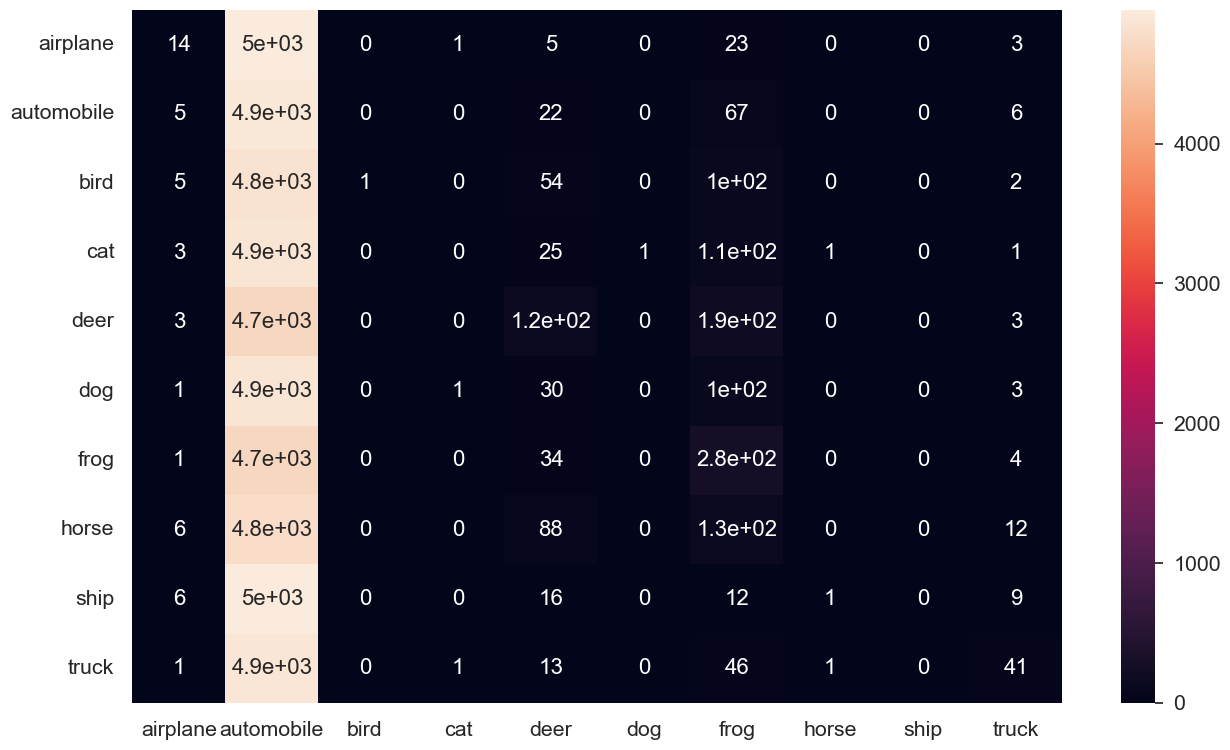

              precision    recall  f1-score   support

    airplane       0.31      0.00      0.01      5000
  automobile       0.10      0.98      0.18      5000
        bird       1.00      0.00      0.00      5000
         cat       0.00      0.00      0.00      5000
        deer       0.30      0.02      0.05      5000
         dog       0.00      0.00      0.00      5000
        frog       0.26      0.06      0.09      5000
       horse       0.00      0.00      0.00      5000
        ship       0.00      0.00      0.00      5000
       truck       0.49      0.01      0.02      5000

   micro avg       0.11      0.11      0.11     50000
   macro avg       0.25      0.11      0.03     50000
weighted avg       0.25      0.11      0.03     50000
 samples avg       0.11      0.11      0.11     50000

Runtime of the algorithm is  117.539  seconds
CPU times: user 14min 8s, sys: 27.9 s, total: 14min 36s
Wall time: 1min 57s


/Users/Admin/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


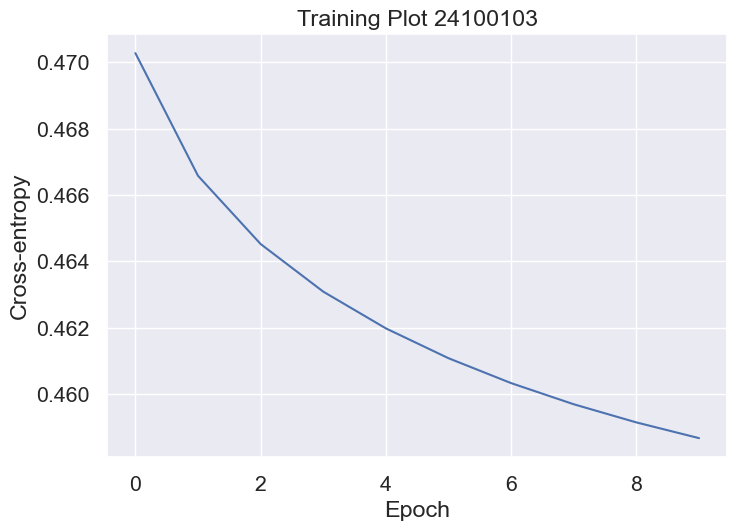

In [178]:
%%time
# starting time
start = time.time()
# Define the input size and output size of Cifar10 dataset

nn = NeuralNetwork(nodes_per_layer=[3072, 32, 16, 10],mode='classification',confusion_matrix=True)
# You can tweak the learning rate and epochs to get the optimal results
history = nn.fit(x_train_1d, y_train_encoding, epochs=10, lr=0.31)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber));
# end time
end = time.time()
print("Runtime of the algorithm is ",round((end - start),3)," seconds")

### Regression for Task

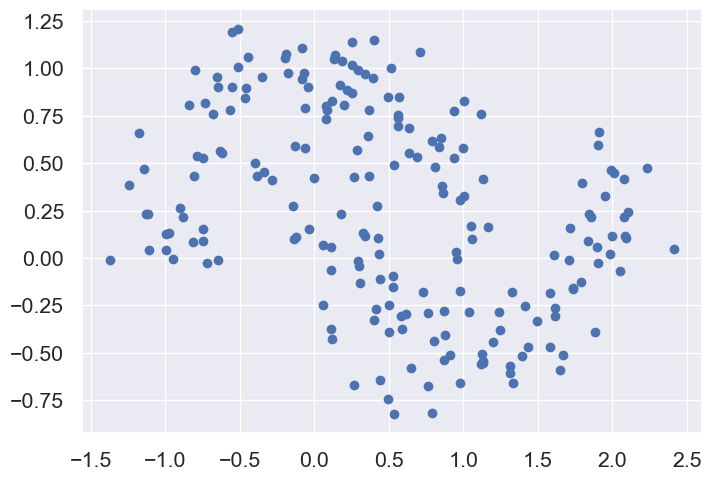

In [179]:
data_x, _ = make_moons(200, noise=0.18)
plt.scatter(data_x[:,0], data_x[:,1]);

__Running time to beat:__
<br>
<br>**CPU times: user 3min 10s, sys: 20.4 s, total: 3min 30s
Wall time: 3min 18s**<br>
<br>

### Your running time will be graded.

In [180]:
reg = LinearRegression()
reg = reg.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
d = np.arange(-1.5, 2.5, 0.1).reshape((40,1))
preds = reg.predict(d)

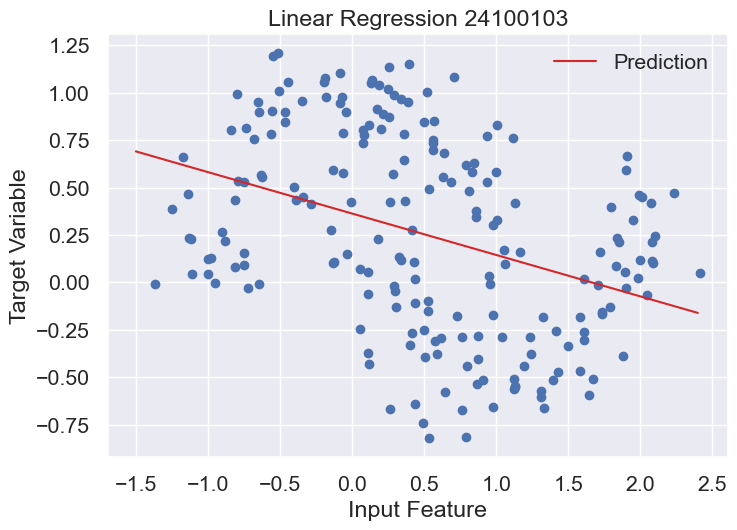

In [181]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Linear Regression {}'.format("24100103"));
ax.legend();

  0%|          | 0/2000 [00:00<?, ?it/s]

Runtime of the algorithm is  20.089  seconds
CPU times: user 20.1 s, sys: 323 ms, total: 20.5 s
Wall time: 20.1 s


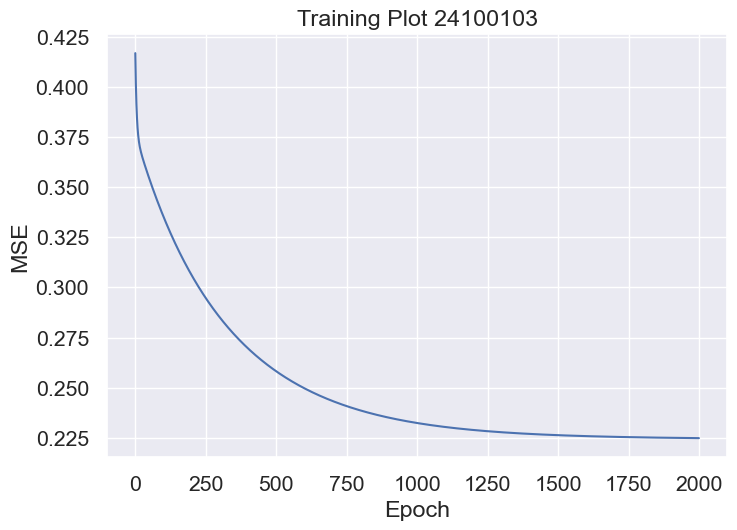

In [182]:
%%time

# starting time
start = time.time()

nn = NeuralNetwork([1,10,20,10,1], 'regression')
history = nn.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)), epochs=2000, lr=1e-4)
preds = nn.predict(d)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}'.format(rollnumber));
# end time
end = time.time()
print("Runtime of the algorithm is ",round((end - start),3)," seconds")

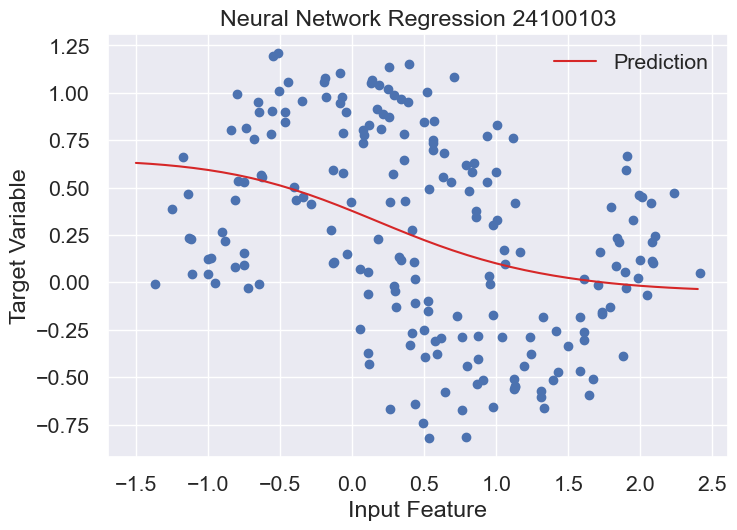

In [183]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Neural Network Regression {}'.format(rollnumber));
ax.legend();

## Dummy Regression Task

In [184]:
a = np.random.uniform(low=0.0, high=0.5, size=(150,))
b = np.random.uniform(low=0.0, high=0.5, size=(150,))
dataset = pd.DataFrame({
    'var1':   a,
    'var2':   b,
    'output': a+b,
})
print(dataset.shape)
dataset.head()

(150, 3)


,var1,var2,output
0,0.063164,0.136824,0.199989
1,0.414385,0.279826,0.694211
2,0.413890,0.070422,0.484312
3,0.042508,0.218299,0.260807
4,0.307274,0.330679,0.637953


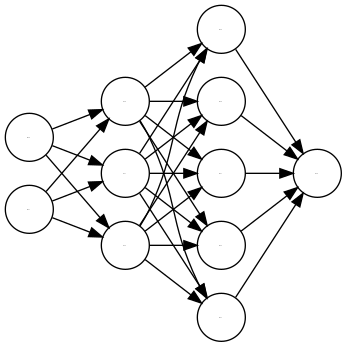

In [185]:
nn = NeuralNetwork([2,3,5,1], 'regression')
nn.plot_model('graph.png')
Image('graph.png')

  0%|          | 0/2000 [00:00<?, ?it/s]

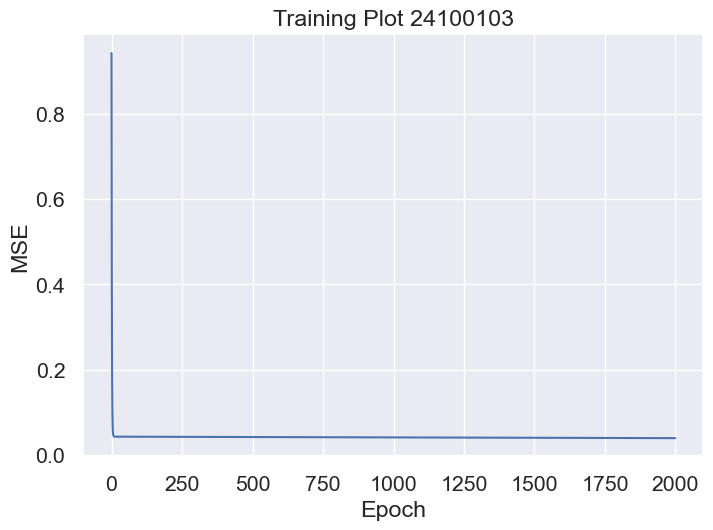

In [186]:
history = nn.fit(dataset[['var1','var2']].values, dataset[['output']].values, epochs=2000, lr=0.001)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}'.format(rollnumber));

In [187]:
test_data = np.array([[0.4,0.1],
                      [0.2,0.3]])
nn.predict(test_data)

array([[0.49204386],
       [0.49953714]])

## Dummy Classification Task

In [209]:
# XOR logic operator
dataset = pd.DataFrame({
    'var1':   [0, 0, 1, 1],
    'var2':   [0, 1, 0, 1],
    'output': [0, 1, 1, 0],
})
dataset = pd.get_dummies(dataset, columns=['output'])
dataset['output'] = pd.Series([0, 1, 1, 0])
print(dataset.shape)
dataset.head()
# The columns 'output_0' and 'output_1' are one-hot encoded representation of the categorical column 'output'

(4, 5)


,var1,var2,output_0,output_1,output
0,0,0,1,0,0
1,0,1,0,1,1
2,1,0,0,1,1
3,1,1,1,0,0


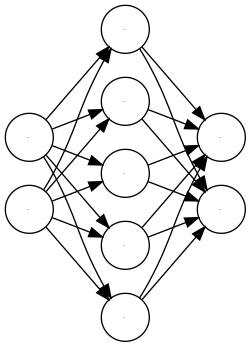

In [210]:
nn = NeuralNetwork([2,5,2], 'classification', confusion_matrix = False)
nn.plot_model('graph.png')
Image('graph.png')

  0%|          | 0/3000 [00:00<?, ?it/s]

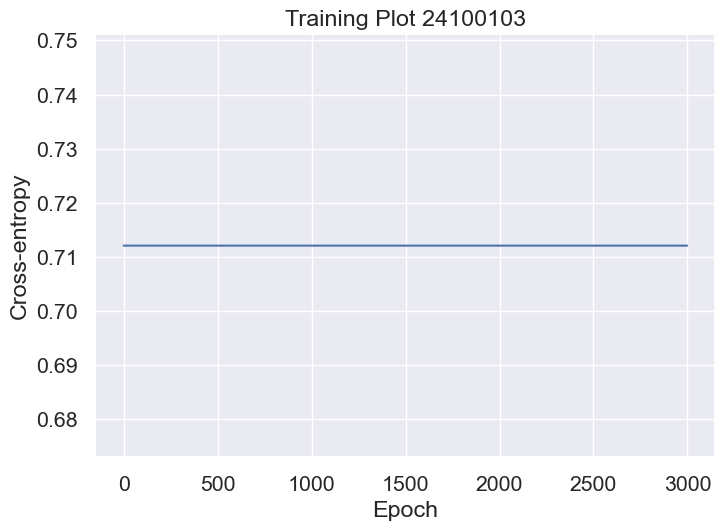

In [215]:
history = nn.fit(dataset[['var1','var2']].values, dataset[['output_0','output_1']].values, epochs=3000, lr=0.01)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber));

In [191]:
nn.predict(dataset[['var1','var2']].values).argmax(axis=1) == dataset[['output_0','output_1']].values.argmax(axis=1)

array([ True, False, False,  True])

## Regression Demo

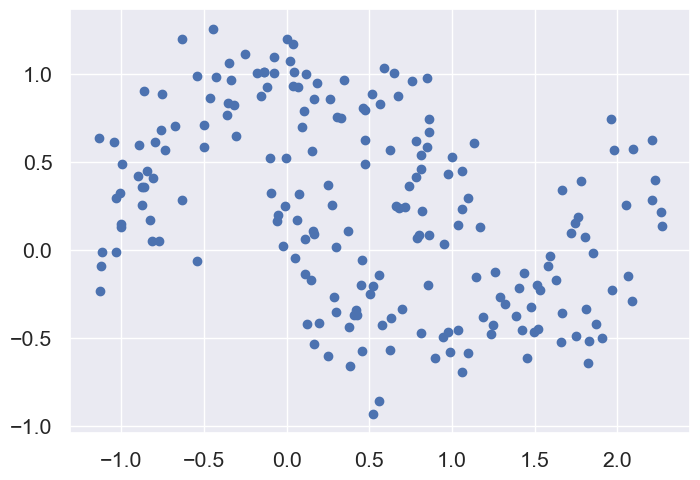

In [192]:
data_x, _ = make_moons(200, noise=0.18)
plt.scatter(data_x[:,0], data_x[:,1]);

In [193]:
reg = LinearRegression()
reg = reg.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));

d = np.arange(-1.5, 2.5, 0.1).reshape((40,1))
preds = reg.predict(d)

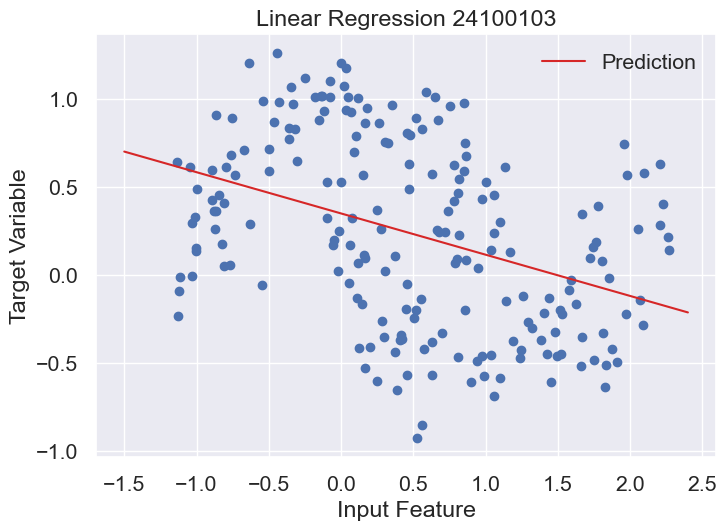

In [194]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Linear Regression {}'.format(rollnumber));
ax.legend();

  0%|          | 0/20000 [00:00<?, ?it/s]

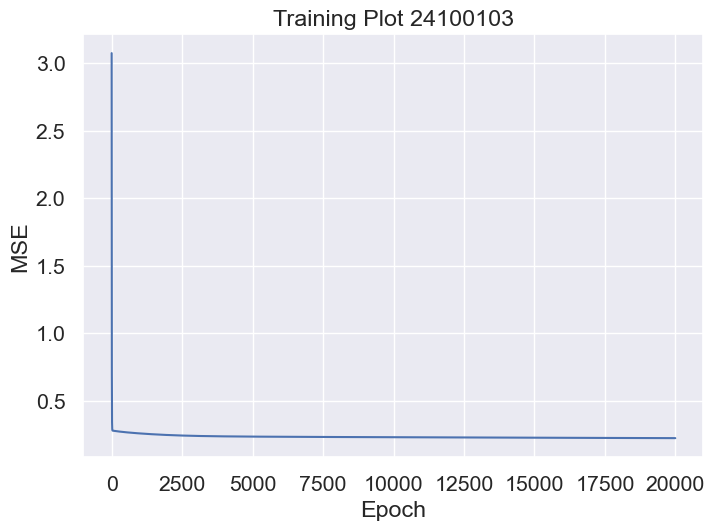

In [195]:
nn = NeuralNetwork([1,10,20,10,1], 'regression')
history = nn.fit(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)), epochs=20000, lr=1e-4)
preds = nn.predict(d)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='MSE', title='Training Plot {}'.format(rollnumber));

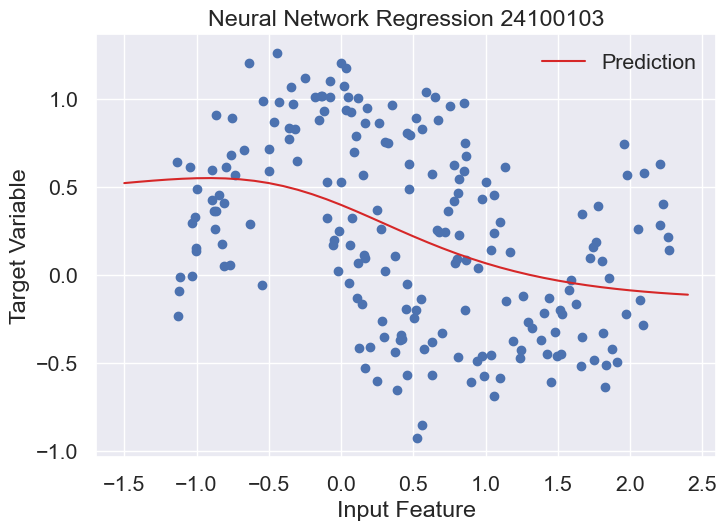

In [196]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input Feature', ylabel='Target Variable', title='Neural Network Regression {}'.format(rollnumber));
ax.legend();

## Classification Demo

In [197]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry
def plot_decision_boundary(pred_func, x_min, x_max, y_min, y_max, cmap, ax):
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.flatten(), yy.flatten()])
    Z = Z.reshape(xx.shape)
    # Plot the contour
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)

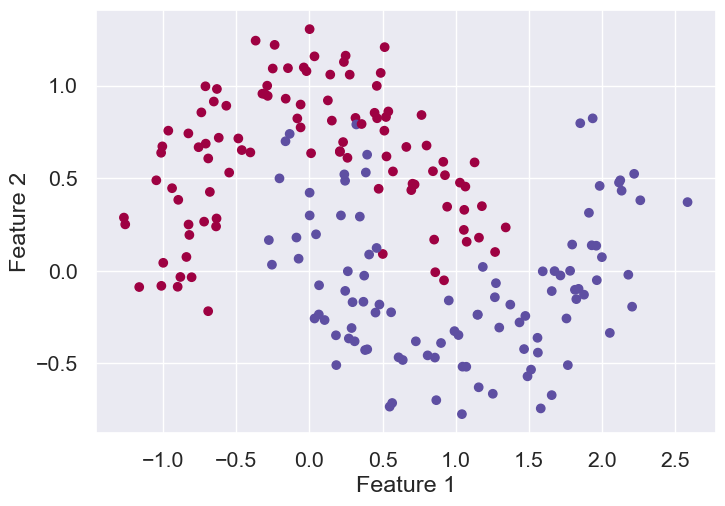

In [198]:
data_x, data_y = make_moons(200, noise=0.20)
plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
plt.gca().set(xlabel='Feature 1', ylabel='Feature 2');

In [199]:
clf = LogisticRegression(solver='lbfgs')
clf = clf.fit(data_x, data_y);

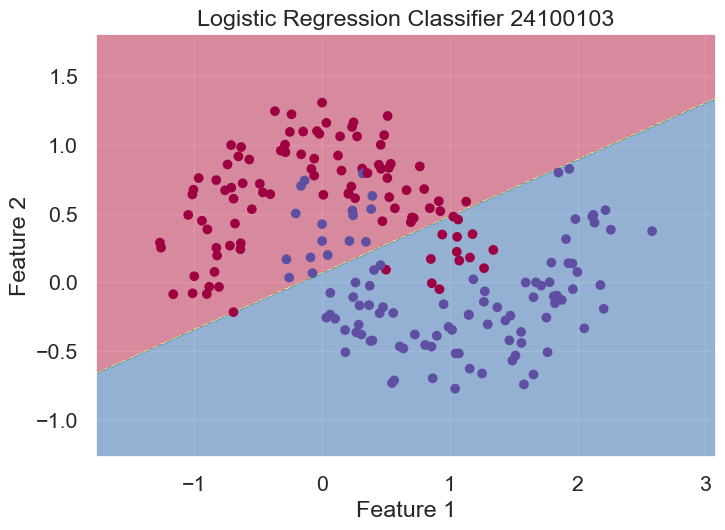

In [200]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: clf.predict(x), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title='Logistic Regression Classifier {}'.format(rollnumber));

  0%|          | 0/2000 [00:00<?, ?it/s]

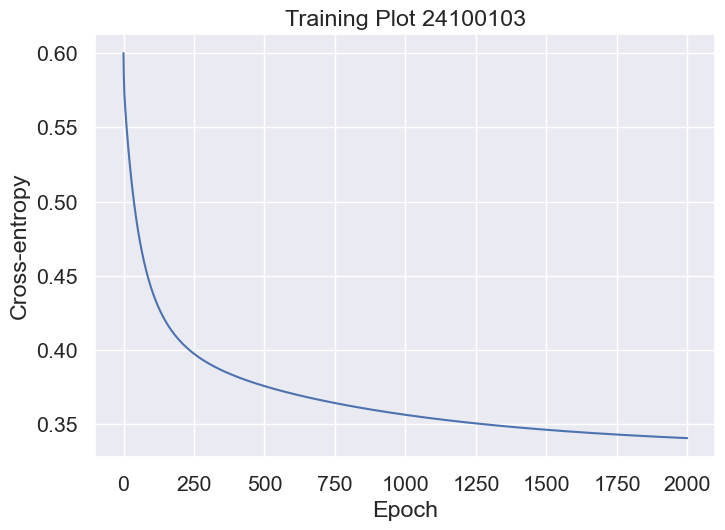

In [201]:
nn = NeuralNetwork([2,10,10,2], 'classification', confusion_matrix=False)
history = nn.fit(data_x, pd.get_dummies(data_y).values, epochs=2000, lr=1e-3)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber));

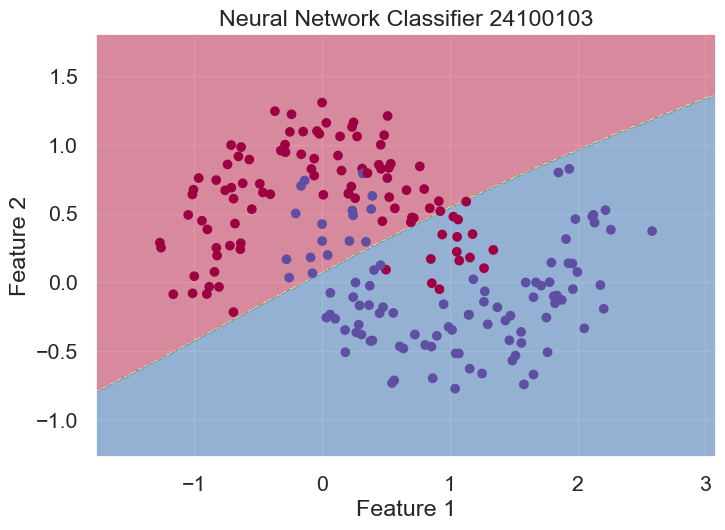

In [202]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title='Neural Network Classifier {}'.format(rollnumber));